In [1]:
#from ipynb.fs.full.google_wv_model import relatedness
import numpy as np

In [2]:
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

unable to import 'smart_open.gcs', disabling that module


In [3]:
string_docs = [' '.join(d) for d in np.load('toxic_classification_traindata_2.npy')]
print(string_docs[:2])

['cocksucker piss around work', 'hey talk exclusive group wp talibans good destroying self appointed purist gang asks questions abt anti social destructive non contribution wp ask clean behavior issue nonsensical warnings']


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
 
vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z][a-zA-Z]{2,}')

data_vectorized = vectorizer.fit_transform(string_docs)

terms = vectorizer.get_feature_names()

In [5]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(data_vectorized);

xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [6]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [7]:
from itertools import combinations

def calculate_coherence(model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [8]:
from sklearn.decomposition import NMF

def get_nda_models(start, limit = 40, step = 6):
    model_list = []
    for num_topics in range(start, limit, step):
        model = NMF(n_components=num_topics, init='nndsvd')
        W = model.fit(xtfidf_norm)
        H = model.components_ 
        # store for later
        model_list.append( (num_topics,W,H) )  
    return model_list

In [9]:
model_list = get_nda_models(start = 2, limit = 40, step = 6)

In [10]:
k_values = []
coherence_values = []
for (k,W,H) in model_list:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherence_values.append( calculate_coherence( model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherence_values[-1] ) )

K=02: Coherence=0.3079
K=08: Coherence=0.2170
K=14: Coherence=0.1873
K=20: Coherence=0.1726
K=26: Coherence=0.1669
K=32: Coherence=0.1590
K=38: Coherence=0.1603


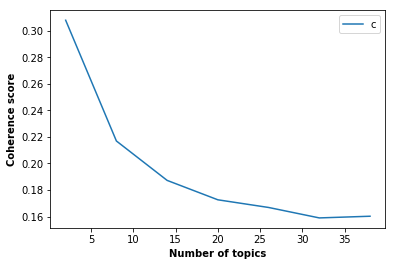

In [12]:
# Plotting the coherence score based on the number of models

import matplotlib.pyplot as plt

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics", fontweight='bold')
plt.ylabel("Coherence score", fontweight='bold')
plt.legend(("coherence_values"), loc='best')
plt.show()

In [13]:
# Save the NMF model with best coherence score from NMF model

import joblib

model_props_bcs = model_list[coherence_values.index(max(coherence_values))]
nmf_model_bcs = model_props_bcs[1]
joblib.dump(nmf_model_bcs, 'nmf_bcs.jl')

model_props_8 = model_list[1]
nmf_model_8 = model_props_8[1]
joblib.dump(nmf_model_8, 'nmf_8.jl')

['nmf_8.jl']

In [14]:
def find_topic_words(model_props, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    topic_words = [];
    for i in range(model_props[0]):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model_props[1].components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        topic_words.append(words);
    
    return topic_words

In [15]:
topic_words_bcs = find_topic_words(model_props_bcs, 20)
topic_words_8 = find_topic_words(model_props_8, 20)

In [17]:
# Save the topic words in a text file

with open("nmf_topic_words_bcs.txt", "w") as txt_file:
    for line in topic_words_bcs:
        txt_file.write(" ".join(line) + "\n")
txt_file.close()

with open("nmf_topic_words_8.txt", "w") as txt_file:
    for line in topic_words_8:
        txt_file.write(" ".join(line) + "\n")
txt_file.close()

In [ ]:
y = []
for doc in newsgroups_data:
    prediction = nmf_model.transform(normalize(transformer.transform(vectorizer.transform([doc])), norm='l1', axis=1))[0]
    #y.append([1 if pred_topic >= np.mean(prediction) else 0 for pred_topic in prediction])
    y.append([pred_topic for pred_topic in prediction])

In [22]:
# Save the y vector in a .npy file

#np.save('y_nmf.npy', y)
np.save('y_realvalue_nmf_2.npy', y)

In [2]:
# loading a model

import joblib

nmf_model = joblib.load('nmf_2.jl')